
Testing RELIANCE for date 2020-01-01 over 5 days:
Warnings:
Nearest available date is 2020-01-08.

Start Price on 2020-01-02 00:00:00: 1382.47
End Price on 2020-01-08 00:00:00: 1383.52
Total Return over 5 days: 0.08%

Testing TCS for date 2020-01-02 over 3 days:
Warnings:
Nearest available date is 2020-01-07.

Start Price on 2020-01-03 00:00:00: 2164.0
End Price on 2020-01-07 00:00:00: 2205.85
Total Return over 3 days: 1.93%

Testing HDFCBANK for date 2020-01-03 over 4 days:
Warnings:
Nearest available date is 2020-01-09.

Start Price on 2020-01-06 00:00:00: 1260.0
End Price on 2020-01-09 00:00:00: 1271.4
Total Return over 4 days: 0.90%

Testing INFY for date 2020-01-04 over 5 days:
Reference date 2020-01-04 not found for ticker INFY.

Testing AAPL for date 2020-01-05 over 5 days:
Reference date 2020-01-05 not found for ticker AAPL.

Testing GOOGL for date 2020-01-06 over 2 days:
Reference date 2020-01-06 not found for ticker GOOGL.


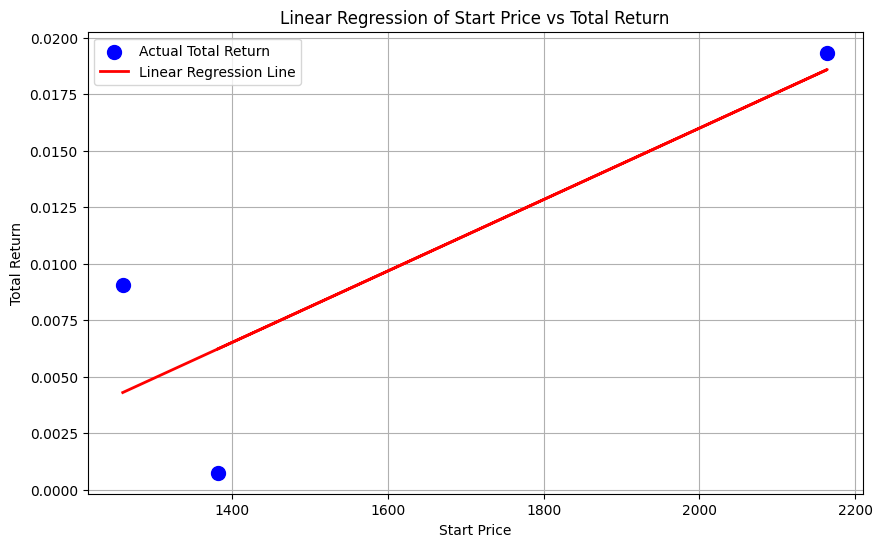

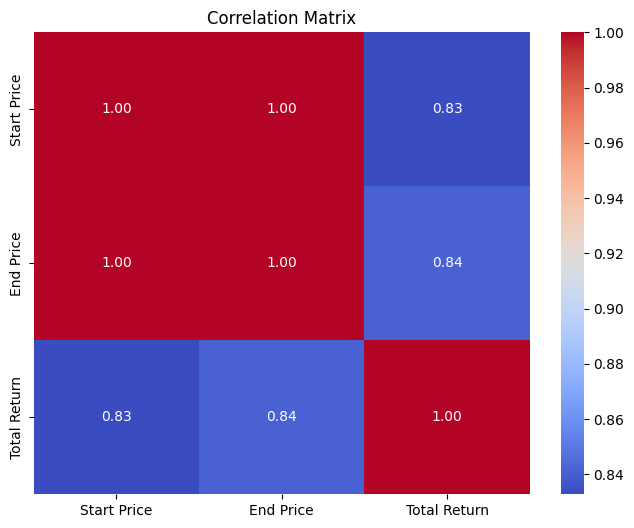

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the adjusted stock data, dividend data, and analyst data
stocksplited_df = pd.read_csv('adjusted_stock_data.csv')
dividend_rows = pd.read_csv('dividend_rows.csv')

# Create dummy data for analysts_df with correct columns
data = {
    'Symbol': ['RELIANCE', 'TCS', 'HDFCBANK', 'INFY', 'AAPL', 'GOOGL'],
    'Date': pd.date_range(start='2020-01-01', periods=6, freq='D'),
    'TargetPrice': [2000, 3000, 1500, 2500, 100, 2000]  # Random target prices
}
analysts_df = pd.DataFrame(data)

# Ensure the Date columns are in datetime format
stocksplited_df['Date'] = pd.to_datetime(stocksplited_df['Date'])
dividend_rows['Date'] = pd.to_datetime(dividend_rows['Date'])
analysts_df['Date'] = pd.to_datetime(analysts_df['Date'])

def predict_n_day_return(ticker, date_d, n, stock_df, dividend_df, analyst_df):
    # Filter stock data for the given ticker and sort by Date
    ticker_stock_df = stock_df[stock_df['Symbol'] == ticker].sort_values('Date').reset_index(drop=True)
    
    # Convert the reference date to datetime
    reference_date = pd.to_datetime(date_d)
    
    ref_index = ticker_stock_df[ticker_stock_df['Date'] == reference_date].index
    if ref_index.empty:
        raise ValueError(f"Reference date {date_d} not found for ticker {ticker}.")
    ref_index = ref_index[0]
    
    # Determine the start index (d+1)
    start_index = ref_index + 1
    if start_index >= len(ticker_stock_df):
        raise IndexError("Insufficient data to determine d+1.")
    
    # Get the start price at d+1
    start_row = ticker_stock_df.iloc[start_index]
    start_price = start_row['Open']
    start_date_used = start_row['Date']
    warnings = ""

    # Initialize dividend and total return tracking
    total_dividend = 0.0
    end_price = None
    end_date_used = None

    # Loop through the next n days to find the end price and calculate dividends
    for i in range(n):
        current_index = start_index + i
        if current_index < len(ticker_stock_df):
            current_row = ticker_stock_df.iloc[current_index]
            current_date = current_row['Date']

            # Filter dividend data for the company in the current date range
            company_dividends = dividend_df[
                (dividend_df['Symbol'] == ticker) & 
                (dividend_df['Date'] >= start_date_used) & 
                (dividend_df['Date'] <= current_date)
            ]
            
            # Calculate total dividends during the period
            total_dividend += company_dividends['Dividend'].sum() if not company_dividends.empty else 0
            
            # Get analyst ratings for the current date
            analyst_ratings = analyst_df[
                (analyst_df['Symbol'] == ticker) & 
                (analyst_df['Date'] == current_date)
            ]
            
            # Modify the end price based on analyst ratings
            if not analyst_ratings.empty:
                current_rating = analyst_ratings.iloc[0]
                if 'TargetPrice' in current_rating and pd.notnull(current_rating['TargetPrice']):
                    adjusted_price = current_row['Close'] * (current_rating['TargetPrice'] / current_row['Close'])
                    end_price = adjusted_price
                else:
                    end_price = current_row['Close']
            else:
                end_price = current_row['Close']
            
            end_date_used = current_row['Date']
        else:
            warnings += f"Skipping date {ticker_stock_df.iloc[min(len(ticker_stock_df) - 1, current_index)]['Date'].date()} as no data is available.\n"
            break  # Exit the loop if no data is available for the current index.

    if end_date_used is None:
        warnings += f"No valid end date found within the range.\n"
    elif end_date_used != reference_date + pd.Timedelta(days=1+n):
        warnings += f"Nearest available date is {end_date_used.date()}.\n"
    
    total_return = None
    if end_price is not None:
        total_return = ((end_price - start_price) + total_dividend) / start_price
    
    return start_price, end_price, total_return, start_date_used, end_date_used, warnings

# Testing the function with various companies and dates
def test_predict_n_day_return():
    test_cases = [
        ('RELIANCE', '2020-01-01', 5),
        ('TCS', '2020-01-02', 3),
        ('HDFCBANK', '2020-01-03', 4),
        ('INFY', '2020-01-04', 5),
        ('AAPL', '2020-01-05', 5),
        ('GOOGL', '2020-01-06', 2)
    ]
    
    results = []
    
    for ticker, date_d, n in test_cases:
        print(f"\nTesting {ticker} for date {date_d} over {n} days:")
        try:
            start_price, end_price, total_return, start_date_used, end_date_used, warnings = predict_n_day_return(ticker, date_d, n, stocksplited_df, dividend_rows, analysts_df)
            
            if warnings:
                print("Warnings:")
                print(warnings)
            
            print(f"Start Price on {start_date_used}: {start_price}")
            
            if end_price is not None:
                print(f"End Price on {end_date_used}: {end_price}")
                print(f"Total Return over {n} days: {total_return:.2%}")
                results.append((start_price, end_price, total_return))
            else:
                print("End price data is unavailable for the given date range.")
        except (ValueError, IndexError) as e:
            print(e)

    # Perform Linear Regression Analysis
    analyze_results(results)

def analyze_results(results):
    """Analyze and visualize the results of stock returns."""
    if results:
        df_results = pd.DataFrame(results, columns=['Start Price', 'End Price', 'Total Return'])

        # Linear Regression
        X = df_results[['Start Price']].values.reshape(-1, 1)
        y = df_results['Total Return'].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predicting values for the linear regression line
        y_pred = model.predict(X)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(X, y, color='blue', label='Actual Total Return', s=100)
        plt.plot(X, y_pred, color='red', label='Linear Regression Line', linewidth=2)
        plt.title('Linear Regression of Start Price vs Total Return')
        plt.xlabel('Start Price')
        plt.ylabel('Total Return')
        plt.legend()
        plt.grid()
        plt.show()

        # Correlation Matrix
        correlation_matrix = df_results.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title('Correlation Matrix')
        plt.show()

# Run the test function
test_predict_n_day_return()
